# Student Info & Imports

Student info: Nadav Kahlon, ID: 213438575

In [83]:
# import necessary packages
import torch
import math

# Question 1
In this question I implement and demonstrate a PyTorch tensor constructor that samples its elements from a discrete probability distribution. I decided to use the **alias method** to generate the tensor's elements efficiently, as described [here](https://en.wikipedia.org/wiki/Alias_method).

I use 2 functions to complete this task:
* 'alias_preproc' generates the probability table U and the alias table K (see [here](https://en.wikipedia.org/wiki/Alias_method#Table_generation)).
* 'my_sampler' samples from the distribution using these tables, and creates the required tensor.

The next cell includes their definitions.

In [84]:
'''
alias_preproc : preprocessing of the alias method for sampling data from discrete
  distribution.
Input:
  > 'dist' - a tensor of floats of shape (n) representing the distribution;
    for each i, dist[i] represents the probability to sample i.
Returns: (U, K), where:
  > 'U' is the probability table used by the alias method, represented by a tensor
    of floats of shape (n).
  > 'K' is the alias table used by the alias method, represented by a tensor of
    (long) integers of shape (n). Uninitialized entries will be -1.
Note: the function ASSUMES that the distribution (the input) is valid.
For more detail regarding the alias method, visit: 
    https://en.wikipedia.org/wiki/Alias_method
'''
def alias_preproc(dist):
    # initialize output
    n = dist.numel()
    U = n * dist
    K = torch.full_like(dist, dtype=torch.long,
                        fill_value=-1) # -1 represents "not yet initialized"

    # run the preprocessing algorithm, and stop when all entries are full; it is 
    # guaranteed to finish after n-1 iterations
    for i in range(dist.numel()-1):

        # end if all entries are "exactly full":
        if torch.all(torch.logical_or(U == 1.0, K >= 0)):
            break
        
        # pick an overfull entry i and an underfull entry j (using a greedy method)
        inf_tensor = torch.full_like(U, fill_value=torch.inf)
        i = torch.argmax(U).item()
        j = torch.argmin(torch.where(K < 0, U, inf_tensor)).item() # (note how we discard
                                                                   # initialized entries of K)

        # "transfer probabilities" from U[i] to U[j]
        K[j] = i
        U[i] = U[i] - (1-U[j])
    
    return U, K


'''
my_sampler : constructs a new PyTorch tensor whose elements are drawn from a given
  discrete distribution.
Input:
  > 'size' - shape of the output tensor.
  > 'dist' - a list (or list-like) of n floats representing the distribution;
    for each i, dist[i] represents the probability to sample i.
  > 'requires_grad' - if autograd should record operations on the returned tensor.
    Default: False.
Returns: the required tensor of shape 'size'.
Throws as assertion error if the input distribution is not valid:
  * 'dist' should be 1 dimensional;
  * The elemnts of 'dist' should be non-negative, and sum-up to 1.
'''
def my_sampler(size, dist, requires_grad=False):
    # for easier manipulation, we transform the distribution list to a tensor
    dist = torch.tensor(dist)

    # check validity of the distribution
    assert (len(dist.shape) == 1 and torch.all(dist >= 0) and
            dist.sum() == 1.0), 'the given distribution is not valid.'
    
    # preprocessing
    U, K = alias_preproc(dist)

    # draw 'x', 'i', and 'y' (in terms of the alias method)
    n = dist.numel()
    x = torch.rand(size)
    i = torch.floor(n*x).long()
    y = n*x - i

    # use the alias tables to draw the actual output
    output = torch.where(y < U[i], i, K[i]).float().clone().detach().requires_grad_(requires_grad)
    
    return output

Next, we demonstrate the sampling function by drawing 10,000 samples from the distribution [0.1, 0.2, 0.7]:

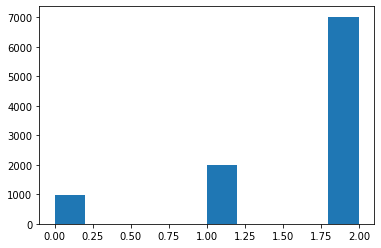

In [85]:
# sample data
dist = [0.1, 0.2, 0.7]
size = (10000)
samples_tensor = my_sampler(size, dist)

# plot histogram
from matplotlib import pyplot as plt
_ = plt.hist(samples_tensor)

More input & output examples:

In [86]:
# simple sampling example
my_sampler(10, [0.5,0.5])


tensor([0., 1., 0., 1., 0., 0., 1., 0., 1., 0.])

In [87]:
# requires_grad=True example
A = my_sampler((2,8), [0.1,0.2,0.7], requires_grad=True)
print(A, A.grad, sep='\n')

tensor([[2., 2., 2., 2., 2., 2., 0., 2.],
        [1., 2., 2., 2., 2., 2., 2., 2.]], requires_grad=True)
None


In [88]:
# calculating gradiant example
A = my_sampler((2,8),[0.1,0.2,0.7],requires_grad=True)
B = (A**2).sum()
B.backward()
print(A,A.grad,sep='\n')

tensor([[2., 2., 2., 2., 2., 2., 2., 2.],
        [2., 1., 2., 2., 1., 1., 1., 2.]], requires_grad=True)
tensor([[4., 4., 4., 4., 4., 4., 4., 4.],
        [4., 2., 4., 4., 2., 2., 2., 4.]])


#Question 2
In this question I implement the broadcasting functionality of PyTorch.

##Part A - 'expand_as' Functionality

Here I implement a mechanism to broadcast one tensor to another tensor's shape. I decided to use 2 functions to implement this:
* 'expand_to' - to broadcast a tensor to a specific shape.
* 'my_expand_as' - to broadcast a tensor to the shape of some other tensor.
They ar defined in in the following cell.

In [89]:
'''
expand_to : broadcasts a tensor to a specific shape.
Input:
    > 'A' - the tensor to broadcast.
    > 'size' - the size to broadcast to.
Output: a new tensor - the broadcasted version of 'A', or None if A is not 
    broadcastable to 'size'.
'''
def expand_to(A, size):
    # allocate a new tensor to represents the output
    A = A.clone()

    # traverse 'size' and 'A.shape' backwards to make them compatible:
    i_a = len(A.shape) - 1 # index into A's shape
    i_s = len(size) - 1 # index into 'size'
    while i_a >= 0 or i_s >= 0:

        if i_a < 0:
            # if reached the beginning of A's shape - add dummy singleton dimension
            A.unsqueeze_(0)
            i_a += 1
        
        # can't broadcast if 'size' is too short or if a target dimension does not
        # match a source's non-singleton dimension
        if i_s < 0 or (size[i_s] != A.shape[i_a] and A.shape[i_a] != 1):
            return None
        
        if A.shape[i_a] == 1 and A.shape[i_a] != size[i_s]:
            # expand A if A's singleton dimension does not match 'size' entry by
            # concatenating A to itself on the required dimension
            A = torch.cat([A] * size[i_s], dim=i_a)

        # update indices for the next iteration
        i_a -= 1
        i_s -= 1

    return A


'''
my_expand_as : broadcasts a tensor into the shape of another tensor.
Input:
    > 'A' - the tensor to broadcast.
    > 'B' - the tensor whose shape is the shape to broadcast 'A' to.
Output: a new tensor - the broadcasted version of 'A'.
Throws an assertion error if 'A' is not  broadcastable to B's shape.
'''
def my_expand_as(A, B):
    # we simply use 'expand_to' with B's shape as the target shape
    result = expand_to(A, B.shape)
    assert result != None, ('tensor of shape ' + str(tuple(A.shape)) +
                            ' is not broadcastible to shape ' + str(tuple(B.shape)))
    return result

##Part B - Checking Broadcastability

In [90]:
'''
are_broadcastible : checks if 2 tensors can be broadcasted together, and calculates
  the broadcasted shape.
Input:
  > 'A' - first tensor.
  > 'B' - second tensor
Retruns: (is_possible, size), where:
  > 'is_possible' is True if tensors are broadcastable together, and False otherwise.
  > 'size' is the broadcasted shape of the tensors, or None if they are not
      broadcastable together.
'''
def are_broadcastible(A, B):
    # we use the simple rules introduced in class, and scan both shapes backwards
    i_a = len(A.shape)-1 # index into A's shape
    i_b = len(B.shape)-1 # index into B's shape
    size =  [] # list to record the resulting shape
    while i_a >= 0 or i_b >= 0:
        
        # check for cases in which one of the dimensions is missing
        if i_a < 0:
            size.insert(0, B.shape[i_b])
        elif i_b < 0:
            size.insert(0, A.shape[i_a])

        # check for the case in which dimensions are equal
        elif A.shape[i_a] == B.shape[i_b]:
            size.insert(0, A.shape[i_a])

        # check for cases in which one of the dimensions is a singletom
        elif A.shape[i_a] == 1:
            size.insert(0, B.shape[i_b])
        elif B.shape[i_b] == 1:
            size.insert(0, A.shape[i_a])

        # otherwise - dimensions are not compatible
        else:
            return False, None

        # update indices for the next iteration
        i_a -= 1
        i_b -= 1
    
    return True, size

##Part C - Broadcasting Tensors Together

In [91]:
'''
my_broadcast_tensors : broadcasts 2 tensors together
Input:
  > 'A' & 'B' - the tensor to broadcast.
Returns: 'A_new', 'B_new' - the broadcasted versions of 'A' and 'B'.
Throws an assertion error if tensors cannot be broadcasted together
'''
def my_broadcast_tensors(A, B):
    # calculate the broadcasted size
    is_possible, size = are_broadcastible(A, B)

    # make sure they're broadcastible
    assert is_possible, ('tensors of shapes ' + str(tuple(A.shape)) + ' and ' +
                         str(tuple(B.shape)) + ' cannot be broadcasted together')
    
    # and broadcast them
    return expand_to(A, size), expand_to(B, size)

##Part D - Comparing Our Interface to the Official Interface

In this part we compare our implementation of the broadcasting interface to the official PyTorch implementation.

In [92]:
'''
test_funcs : runs two implementations of the same functionality.
Input:
  > 'imp1' - a function representing the first implementation.
  > 'imp2' - a function representing the second implementation
  > 'A' & 'B' - input to both functions.
Note: we assume both functions accept only 2 arguments - 'A' and 'B'.
Returns (result1, exc1, result2, exc2) where for each i=1,2:
  > 'resulti' is the output of the first implementation.
  > 'exci' is a boolean stating whether an exception occured while running 'impi'.
'''
def test_funcs(imp1, imp2, A, B):
    # try 1st implementation; set exc_1 to True if an exception occured
    exc1 = False
    result1 = None
    try: result1 = imp1(A, B)
    except: exc1 = True

    # try the 2nd implementation; set exc2 to True if an exception occured
    exc2 = False
    result2 = None
    try: result2 = imp2(A, B)
    except: exc2 = True

    return result1, exc1, result2, exc2

In each of the following cells we test our implementations against the official implementations on different test examples using 'test_funcs' defined above.

In [93]:
# check if our 'expand_as' works the same as the official 'expand_as' on the
# following A,B input:
A = torch.arange(    3*1*5).reshape((    3,1,5))
B = torch.arange(1*2*3*4*5).reshape((1,2,3,4,5))

# run test:
result1, exc1, result2, exc2 = test_funcs(my_expand_as, torch.Tensor.expand_as,  A, B)
if torch.equal(result1, result2):
    print('Test passed successfuly; output shape:', tuple(result1.shape), '.')

Test passed successfuly; output shape: (1, 2, 3, 4, 5) .


In [94]:
# check if our 'expand_as' works the same as the official 'expand_as' on the
# following A,B input:
A = torch.arange(    2*1*5).reshape((    2,1,5))
B = torch.arange(1*2*3*4*5).reshape((1,2,3,4,5))

# run test:
result1, exc1, result2, exc2 = test_funcs(my_expand_as, torch.Tensor.expand_as,  A, B)
if exc1 == True and exc2 == True:
    print('Test passed successfuly; both implementations threw an exception.')

Test passed successfuly; both implementations threw an exception.


In [95]:
# check if our 'broadcast_tensors' works the same as the official 'broadcast_tensors' 
# on the following A,B input:
A = torch.arange(    3*1*5).reshape((    3,1,5))
B = torch.arange(1*2*3*4*5).reshape((1,2,3,4,5))

# run test:
result1, exc1, result2, exc2 = test_funcs(my_broadcast_tensors,
                                          torch.broadcast_tensors,
                                          A, B)
result1_A, result1_B = result1
result2_A, result2_B = result2
if torch.equal(result1_A, result2_A) and torch.equal(result1_B, result2_B):
    print('Test passed successfully; output shape:', tuple(result1_A.shape), '.')


Test passed successfully; output shape: (1, 2, 3, 4, 5) .


In [96]:
# check if our 'broadcast_tensors' works the same as the official 'broadcast_tensors' 
# on the following A,B input:
A = torch.arange(    3*1*5).reshape((    3,1,5))
B = torch.arange(1*2*1*4*5).reshape((1,2,1,4,5))

# run test:
result1, exc1, result2, exc2 = test_funcs(my_broadcast_tensors,
                                          torch.broadcast_tensors,
                                          A, B)
result1_A, result1_B = result1
result2_A, result2_B = result2
if torch.equal(result1_A, result2_A) and torch.equal(result1_B, result2_B):
    print('Test passed successfully; output shape:', tuple(result1_A.shape), '.')

Test passed successfully; output shape: (1, 2, 3, 4, 5) .


In [97]:
# check if our 'broadcast_tensors' works the same as the official 'broadcast_tensors' 
# on the following A,B input:
A = torch.arange(    3*2*5).reshape((    3,2,5))
B = torch.arange(1*2*1*4*5).reshape((1,2,1,4,5))

# run test:
result1, exc1, result2, exc2 = test_funcs(my_broadcast_tensors,
                                          torch.broadcast_tensors,
                                          A, B)
if exc1 == True and exc2 == True:
    print('Test passed successfuly; both implementations threw an exception.')

Test passed successfuly; both implementations threw an exception.


#Question 3
In this question I implement a simple  version of the autograd system of PyTorch.
I decided to support **both unary and binary operations** on scalars (with a simple mechanism to actually support any n-ary operation).

The system is based on the 'MyScalar' class that represents scalars.

Each scalar object 's' has 4 attributes:
* s.value: the floating-point value of the scalar.
* s.parents: A list of pairs (parent, parent_grad) where 'parent' is a pointer to another 'MyScalar' objects from which 's' was directly created (using some mathematical operation), and 'parent_d' is the **immediate** derivative of 's' with respect to 'parent'. May be empty for a "root" scalar.
* s.grads_cache: dictionary of derivatives of 's' with respect to every scalar it depends on - indexed by IDs of the corresponding 'MyScalar' objects. May be None if no function had to scan backwards the scalar yet, or if the user does not wish to cache the scalar's derivatives. More detail later.
* s.to_cache_grads: a boolean stating whether the user wishes to cache derivatives of 's' with respect to every ancestor of it (it does not mean that the derivatives have already been cached).

The auto-grad system offered by the 'get_gradient' routine returns a dictionary of derivatives of 's' with respect to scalars it depends on; indexed by IDs of the corresponding 'MyScalar' objects.

The system uses recursive applications of the chain rule to generate those derivatives, using the following algorithm:


```
1. Recursively generate the derivatives with respect to each of the parents of
   's' (found in s.parents).
2. for each scalar 't' on which some parent 'p' of 's' is dependant, calculate
   the derivative of 's' with respect to 't' through 'p' as: [dp/dt] * [dt/ds],
   and add it to the derivative [ds/dt] calculated so far.
3. At last - return a dictionary of the total derivatives, with an entry for
   the derivative of 's' with respect to itself (1.0).

```
Note that we **add** derivatives, due to the fact that the same scalar 't' may affect 's' throguh different parents 'p' of 's'.

Because traversing through the dependences tree may be very costly, the user may wish to cache derivatives of a frequently used scalar with respect to each one of its ancestors (instead of calculating them again and again each time one of its descendants wants its gradients). For that reason I decided to add this caching option, as described in the next cell in th API of the class.

In [98]:
'''
MyScalar : represents a scalar in my auto-grad system.
I highly recommend to manipulate MyScalars objects only through the functional
  interface this class offers. For the sake of simplicity, scalars are immutable
  in this interface (and so is their derivatives cache).
'''
class MyScalar:

    '''
    Constructor : creates a new scalar object with the specified attributes.
    Attributes:
      > 'value' - value of the scalar.
      > 'parents' - list of (parent, parent_grad) pairs where 'parent' is a pointer
        to another MyScalar object from which this scalar was directly created
        (via some mathematical operation), and 'parent_grad' is the derivative of
        this scalar with respect to that parent. Default: empty list (no dependencies).
      > 'to_cache_grads' - a boolean stating whether the user wishes to cache the
        derivatives of the scalar with respect to every ancestor of it, when they
        will be calculated. I recommend to set it to True if it has a lot of 
        descendants whose gradients you wish to calculate later. Default: False.
    '''
    def __init__(self, value, parents=[], to_cache_grads=False):
        # initialization:
        self.value = value
        self.grads_cache = None # nothing is cached yet
        self.to_cache_grads = to_cache_grads

        # create a "semi-deep" copy of 'parents' (necessary if 'parents' is a
        # list of lists of 2 variables and not a list of tuples, in which case
        # a shallow copy is not enough and a deep copy is too much):
        self.parents = []
        for parent, parent_grad in parents:
            self.parents.append((parent, parent_grad))
    
    
    '''
    set_to_cache_grads : sets the 'to_cache_grads' attribute of the MyScalar object.
    Input:
      > 'to_cache_grads' - the value to assign: a boolean stating whether the user
         wishes to cache the derivatives of the scalar with respect to every ancestor 
        of it, when they will be calculated. I recommend to set it to True if it has 
        a lot of  descendants whose gradients you wish to calculate later.
    Note: if derivatives were already cached and now caching is disabled, the cache is
      discarded.
    '''
    def set_to_cache_grads(self, to_cache_grads):
        # set attribute
        self.to_cache_grads = to_cache_grads
        # discard cache in case caching is now disabled
        if to_cache_grads == False:
            self.grads_cache = None


    '''
    get_value : returns the value of the scalar.
    '''
    def get_value(self):
        return self.value


    '''
    get_gradient : calculates gradients of this scalar with respect to every
      other scalar it depend on.
    Returns a dictionary of derivatives, indexed by the IDs of the corresponding
      MyScalar objects.
    '''
    def get_gradient(self):
        # recalculate derivatives if they are not cached:
        if self.grads_cache == None:
            grads_of_self = {} # to hold the result

            # get ancestors' derivatives through direct parents
            for (parent, parent_grad) in self.parents:
                grads_of_parent = parent.get_gradient()

                # record ancestors' derivatives through 'parent'
                for ancestor_id in grads_of_parent.keys():
                    # make sure there is a record of the ancestor, and update it:
                    if ancestor_id not in grads_of_self.keys():
                        grads_of_self[ancestor_id] = 0.0
                    grads_of_self[ancestor_id] += parent_grad * grads_of_parent[ancestor_id]
                    # = d(self)/d(parent) * d(parent) / d(ancestor)
            
            # add entry for 'self' itself:
            grads_of_self[id(self)] = 1.0

            # cache a copy of the derivatives if needed
            if self.to_cache_grads == True:
                self.grads_cache = grads_of_self.copy()
            
            return grads_of_self

        # in case derivatives are cached - return copy of the cache
        else:
            return self.grads_cache.copy()
    

    '''
    __str__ : returns a string representation of the scalar, rounded to 'd' digits after
      the decimal point (default: d=2)
    '''
    def __str__(self, d=2):
        return str(round(self.value, d))


    '''
    __float__ : returns the float value of the scalar.
    '''
    def __float__(self):
        return float(self.value)


    '''
    __add__ : adds another scalar to this scalar, and returns a new MyScalar with the result.
    Input:
      > 'other' - the other scalar to add. May be a simple numeric primitive or another
        MyScalar - in which case the new MyScalar will be a child of 'other' as well as of
        'self' in the gradient dependencies tree.
      > 'to_cache_grads' - a boolean stating whether the user wishes to cache gradients
        of the resulting MyScalar (more detail in MyScalar.__init__ documentation).
        Default: False.
    '''
    def __add__(self, other, to_cache_grads=False):
        # store parents and calculate gradients
        parents = [(self, 1.0)] # d(self+other)/d(self)=1
        if type(other) == MyScalar:
          parents.append((other, 1.0)) # d(self+other)/d(other)=1

        # create and return new MyScalar
        return MyScalar(float(self) + float(other),
                        parents, to_cache_grads)

    '''
    __radd__ : same as '__add__'.
    '''
    def __radd__(self, other, to_cache_grads=False):
        return self.__add__(other, to_cache_grads)


    '''
    __mul__ : multiplies this scalar with another scalar, and returns a new MyScalar with the
      result.
    Input:
      > 'other' - the other scalar to multiply. May be a simple numeric primitive or another
        MyScalar - in which case the new MyScalar will be a child of 'other' (as well as of
        'self') in the gradient dependencies tree.
      > 'to_cache_grads' - a boolean stating whether the user wishes to cache gradients
        of the resulting MyScalar (more detail in MyScalar.__init__ documentation).
        Default: False.
    '''
    def __mul__(self, other, to_cache_grads=False):
        # store parents and calculate gradients
        parents = [(self, float(other))] # d(self*other)/d(self)=other
        if type(other) == MyScalar:
          parents.append((other, float(self))) # d(self*other)/d(other)=self

        # create and return new MyScalar
        return MyScalar(float(self) * float(other),
                        parents, to_cache_grads)
    
    '''
    __rmul__ : same as '__mul__'.
    '''
    def __rmul__(self, other, to_cache_grads=False):
        return self.__mul__(other, to_cache_grads)


    '''
    __truediv__ : divides this scalar by another scalar, and returns a new MyScalar with 
      the result.
    Input:
      > 'other' - the scalar to divide by. May be a simple numeric primitive or another
        MyScalar - in which case the new MyScalar will be a child of 'other' (as well
        as of 'self') in the gradient dependencies tree.
      > 'to_cache_grads' - a boolean stating whether the user wishes to cache gradients
        of the resulting MyScalar (more detail in MyScalar.__init__ documentation).
        Default: False.
    '''
    def __truediv__(self, other, to_cache_grads=False):
        # store parents and calculate gradients
        parents = [(self, 1/float(other))] # d(self/other)/d(self)=1/other
        if type(other) == MyScalar:
            parents.append((other,
                          -float(self)/float(other)**2)) # d(self/other)/d(other)=-self/(other)**2

        # create and return new MyScalar
        return MyScalar(float(self) / float(other),
                        parents, to_cache_grads)
    
    '''
    __rtruediv__ : divides another scalar by this scalar, and returns a new MyScalar with
      the result.
    Input:
      > 'other' - the scalar to divide. May be a simple numeric primitive or another
        MyScalar - in which case the new MyScalar will be a child of 'other' (as well
        as of 'self') in the gradient dependencies tree.
      > 'to_cache_grads' - a boolean stating whether the user wishes to cache gradients
        of the resulting MyScalar (more detail in MyScalar.__init__ documentation).
        Default: False.
    '''
    def __rtruediv__(self, other, to_cache_grads=False):
        # store parents and calculate gradients
        parents = [(self, -float(other)/float(self)**2)] # d(other/self)/d(self)=-other/self**2
        if type(other) == MyScalar:
            parents.append((other, 1/float(self))) # d(other/self)/d(other)=1/self

        # create and return new MyScalar
        return MyScalar(float(other) / float(self),
                        parents, to_cache_grads)

    
    '''
    __pow__ : raises this scalar to the power of another scalar, and returns a new
        MyScalar with the result.
    Input:
      > 'other' - the other scalar (the power). May be a simple numeric primitive or 
        another MyScalar - in which case the new MyScalar will be a child of 'other'
        (as well as of 'self') in the gradient dependencies tree.
      > 'to_cache_grads' - a boolean stating whether the user wishes to cache gradients
        of the resulting MyScalar (more detail in MyScalar.__init__ documentation).
        Default: False.
    '''
    def __pow__(self, other, to_cache_grads=False):
        # store parents and calculate gradients
        parents = [(self, float(other) * (float(self)**(float(other)-1)))]
                          # d(self**other)/d(self)=other*(self)**(other-1)
        if type(other) == MyScalar:
            parents.append((other, float(self)**float(other) * math.log(float(self))))
                                  # d(self**other)/d(other)=self**other*ln(self)

        # create and return new MyScalar
        return MyScalar(float(self)**float(other),
                        parents, to_cache_grads)
    
    '''
    __rpow__ : raises another scalar to the power of this scalar, and returns a new
        MyScalar with the result.
    Input:
      > 'other' - the other scalar (the base). May be a simple numeric primitive or 
        another MyScalar - in which case the new MyScalar will be a child of 'other'
        (as well as of 'self') in the gradient dependencies tree.
      > 'to_cache_grads' - a boolean stating whether the user wishes to cache gradients
        of the resulting MyScalar (more detail in MyScalar.__init__ documentation).
        Default: False.
    '''
    def __rpow__(self, other, to_cache_grads=False):
        # store parents and calculate gradients
        parents = [(self, float(other)**float(self) * math.log(float(other)))]
                          # d(other**self)/d(self)=other**self*ln(other)
        if type(other) == MyScalar:
            parents.append((other, float(self) * (float(other)**(float(self)-1))))
                                   # d(other**self)/d(other)=self*(other)**(self-1)
                                 

        # create and return new MyScalar
        return MyScalar(float(other)**float(self),
                        parents, to_cache_grads)
        
    
    '''
    exp : raises e to the power of the scalar, and returns a new MyScalar object with
      the result.
    Input:
      > 'to_cache_grads' - a boolean stating whether the user wishes to cache gradients
        of the resulting MyScalar (more detail in MyScalar.__init__ documentation).
        Default: False.
    '''
    def exp(self, to_cache_grads=False):
        # simply use __rpow__ defined above
        return self.__rpow__(math.e, to_cache_grads)
    
    '''
    log : calculates the natural log of the scalar and returns a new MyScalar object with
      the result.
    Input:
      > 'to_cache_grads' - a boolean stating whether the user wishes to cache gradients
        of the resulting MyScalar (more detail in MyScalar.__init__ documentation).
        Default: False.
    '''
    def log(self, to_cache_grads=False):
        return MyScalar(math.log(self.value), # result
                        [(self, 1/self.value)], # = d(log(self))/self = 1/self
                        to_cache_grads)
    
    '''
    sin : calculates the sin of the scalar and returns a new MyScalar object with the result.
    Input:
      > 'to_cache_grads' - a boolean stating whether the user wishes to cache gradients
        of the resulting MyScalar (more detail in MyScalar.__init__ documentation).
        Default: False.
    '''
    def sin(self, to_cache_grads=False):
        return MyScalar(math.sin(self.value), # result
                        [(self, math.cos(self.value))], # = d(sin(self))/self = cos(self)
                        to_cache_grads)
    
    '''
    cos : calculates the cos of the scalar and returns a new MyScalar object with the result.
    Input:
      > 'to_cache_grads' - a boolean stating whether the user wishes to cache gradients
        of the resulting MyScalar (more detail in MyScalar.__init__ documentation).
        Default: False.
    '''
    def cos(self, to_cache_grads=False):
        return MyScalar(math.cos(self.value), # result
                        [(self, -math.sin(self.value))], # = d(cos(self))/self = -sin(self)
                        to_cache_grads)

Now that we have the 'MyScalar' class, we can use it to calculate gradients automatically. In the following cell I demonstarte the different functions that the class supplies, and some derivatives of those functions.

In [99]:
# we define a few "root" objects of MyScalar
one = MyScalar(1)
two = MyScalar(2)
ln_5 = MyScalar(math.log(5))
pi_over_2 = MyScalar(math.pi / 2)

# we use them to calculate new scalars using various operations
one_plus_two = one + two
one_times_two = one * two
one_over_two = one / two
two_to_the_one = two ** one
exp_ln_5 = ln_5.exp()
ln_of_two = two.log()
cos_pi_over_2 = pi_over_2.cos()
sin_pi_over_2 = pi_over_2.sin()

# and calculate some derivatives
print('d(one+two)/d(one) =', one_plus_two.get_gradient()[id(one)])
print('d(one*two)/d(two) =', one_times_two.get_gradient()[id(two)])
print('d(one/two)/d(two) =', one_over_two.get_gradient()[id(two)])
print('d(two**one)/d(one) =', two_to_the_one.get_gradient()[id(one)])
print('d(exp(ln_5))/d(ln_5) =', exp_ln_5.get_gradient()[id(ln_5)])
print('d(ln(two))/d(two) =', ln_of_two.get_gradient()[id(two)])
print('d(cos(pi_over_2))/d(pi_over_2)', cos_pi_over_2.get_gradient()[id(pi_over_2)])
print('d(sin(pi_over_2))/d(pi_over_2)', sin_pi_over_2.get_gradient()[id(pi_over_2)])

d(one+two)/d(one) = 1.0
d(one*two)/d(two) = 1.0
d(one/two)/d(two) = -0.25
d(two**one)/d(one) = 1.3862943611198906
d(exp(ln_5))/d(ln_5) = 4.999999999999999
d(ln(two))/d(two) = 0.5
d(cos(pi_over_2))/d(pi_over_2) -1.0
d(sin(pi_over_2))/d(pi_over_2) 6.123233995736766e-17


Now let's try to differentiate a more complicated function - the logistic sigmoid:

In [100]:
# calculations:
x = MyScalar(0)
sigmoid_of_x = 1 / (1 + math.e ** ((-1) * x))
derivative = sigmoid_of_x.get_gradient()[id(x)]
# message:
print('x =', x)
print('sigmoid at x =', sigmoid_of_x)
print('derivative =', derivative)


x = 0
sigmoid at x = 0.5
derivative = 0.25


Now let's try antoher complicated function, in which the same scalar affects the result in multiple places:

In [101]:
# calculations:
x = MyScalar(2)
f_of_x = x + (2 * x + x) / (x * x)
derivative = f_of_x.get_gradient()[id(x)]
# message:
print('x =', x)
print('x + (2x+x)/(x*x) =', f_of_x)
print('derivative =', derivative)


x = 2
x + (2x+x)/(x*x) = 3.5
derivative = 0.25


Finally, in the follwong cells we will compare our system to the official PyTorch autograd system.

In the next cell we define 'test_autograd' to test the system with arbitrary mathematical functions (as a composition of the elementry functions), and in the one that follows we test different functions at different 'x' values.

In [102]:
'''
test_autograd : test the autograd system implemented in 'MyScalar' class, against
  the official PyTorch system.
Input:
  > 'f' - any function (of one variable) composed of mathematical operations implemented
    by both the torch.Tensor class and the MyScalar class.
    For instance: f = lambda x: x.log() * x.cos() + x / (x+x)**2
  > 'x' - the (primitive numeric) value at which we wish to test the value of f.
  > 'title' - a string added as the title of the test (or None for no title).
Prints a message regarding the success of the test. Rounds results to 3 digits after the
  decimal point.
'''
def test_autograd(f, x, title=None):
    x = float(x) # so torch autograd can activate

    # print title
    if title != None:
        print(title)

    # perform the necessary calculations with the PyTorch tensor iterface:
    tensor_x = torch.tensor(x, requires_grad=True)
    tensor_fx = f(tensor_x)
    tensor_fx.backward()
    tensor_df = tensor_x.grad
    tensor_fx_val = round(tensor_fx.item(), 3)
    tensor_df_val = round(tensor_df.item(), 3)

    # perform the necessary calculation with the MyScalar interface:
    myscalar_x = MyScalar(x)
    myscalar_fx = f(myscalar_x)
    myscalar_df = myscalar_fx.get_gradient()[id(myscalar_x)]
    myscalar_fx_val = round(myscalar_fx.get_value(), 3)
    myscalar_df_val = round(myscalar_df, 3)

    # and finally - compare the results
    if tensor_fx_val == myscalar_fx_val:
        print('Function evaluated correctly to', myscalar_fx_val)
    else:
        print('Function evaluation failed: expected', tensor_fx_val, 'but got',
               myscalar_fx_val)
    if tensor_df_val == myscalar_df_val:
        print('Derivative evaluated correctly to', myscalar_df_val)
    else:
        print('Derivative evaluation failed: expected', tensor_df_val, 'but got',
              myscalar_df_val)
    print('')

In [103]:
test_autograd(lambda x: x*x, x = 5,
              title='testing funciton x*x at x=5')

test_autograd(lambda x: (x.cos()+x.log())**2, x=3,
              title='testing funciton (cos(x)+log(x))**2 at x=3')

test_autograd(lambda x: x ** (x / x.log()), x=0.5,
              title='testing function x ** (x/log(x)) at x=0.5')

test_autograd(lambda x: 1 / (1 + ((-1) * x).exp()), x=-2,
              title='testing logistic sigmoid function at x=-2')

test_autograd(lambda x: x.cos()+1+x.sin()**2, x=-5,
              title='testing function cos(x)+1+sin(x)**2 at x=-5')

testing funciton x*x at x=5
Function evaluated correctly to 25.0
Derivative evaluated correctly to 10.0

testing funciton (cos(x)+log(x))**2 at x=3
Function evaluated correctly to 0.012
Derivative evaluated correctly to 0.042

testing function x ** (x/log(x)) at x=0.5
Function evaluated correctly to 1.649
Derivative evaluated correctly to 1.649

testing logistic sigmoid function at x=-2
Function evaluated correctly to 0.119
Derivative evaluated correctly to 0.105

testing function cos(x)+1+sin(x)**2 at x=-5
Function evaluated correctly to 2.203
Derivative evaluated correctly to -0.415



Good luck ^_^

Nadav.

